<a href="https://colab.research.google.com/github/mongoq/thesis/blob/main/JB_skin_cancer_model_97_88_accuracy_29bfa6_with_own_diagnosis_labortage22c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# download packages

In [ ]:
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import the libraries

In [2]:
import numpy as np
import pandas as pd

import io
import os
import tensorflow as tf

from PIL import Image
from glob import glob
import itertools

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from IPython.display import display
#To see the value of multiple statements at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# prepare train test splits

In [3]:
def prepare_for_train_test(X, Y):
    # Splitting into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
    
    # Prepare data for training and testing the model
    # train_datagen = ImageDataGenerator(rescale = 1./255,
    #                               rotation_range = 10,
    #                               width_shift_range = 0.2,
    #                               height_shift_range = 0.2,
    #                               shear_range = 0.2,
    #                               horizontal_flip = True,
    #                               vertical_flip = True,
    #                               fill_mode = 'nearest')
    # train_datagen.fit(X_train)
    # test_datagen = ImageDataGenerator(rescale = 1./255)
    # test_datagen.fit(X_test)
    return X_train, X_test, Y_train, Y_test

# Prepare model

In [ ]:
#@title Old Model

def create_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
    return model;


In [ ]:
#@title Stream HAM
!pip3 install deeplake

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 369 kB 4.9 MB/s 
     |████████████████████████████████| 7.6 MB 32.5 MB/s 
     |████████████████████████████████| 132 kB 36.7 MB/s 
     |████████████████████████████████| 79 kB 7.0 MB/s 
     |████████████████████████████████| 6.6 MB 22.1 MB/s 
     |████████████████████████████████| 79 kB 6.9 MB/s 
     |████████████████████████████████| 9.9 MB 31.4 MB/s 
     |████████████████████████████████| 140 kB 41.1 MB/s 
     |████████████████████████████████| 115 kB 18.0 MB/s 
     |████████████████████████████████| 52 kB 1.2 MB/s 
     |████████████████████████████████| 127 kB 51.3 MB/s 
  Created wheel for deeplake: filename=deeplake-3.0.18-py3-none-any.whl size=448195 sha256=48b65909d322969f2dfb2d6b61a6b487d38409e81fa4a7db9e98d29bd5838342
  Stored in directory: /root/.cache/pip/wheels/0d/5e/be/286310851b3ad9a577155e42b61a3f455ab09633e7a42fb70a
Success

In [ ]:
import deeplake
ds = deeplake.load('hub://activeloop/ham10000')

hub://activeloop/ham10000 loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/ham10000


In [ ]:
ds

Dataset(path='hub://activeloop/ham10000', read_only=True, tensors=['ages', 'genders', 'image_ids', 'images', 'lesion_categories', 'lesion_ids', 'localizations', 'sources'])

In [ ]:
#image = ds.images[0]
#image
#%pylab inline
#imshow(image)
ds.lesion_categories.numpy()[500]

array([3], dtype=uint32)

Prepare Resnet50 model

In [51]:
#@title Prepare ResNet

def create_model():
  input_shape=[224,224,3]
  classes=7
  # Create a model and train it on the augmented image data
  inputs = keras.Input(shape=input_shape)
  outputs = keras.applications.ResNet50(  # Add the rest of the model
      weights=none, input_shape=input_shape, classes=classes
  )(inputs)
  model = keras.Model(inputs, outputs)
  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
  model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
  print(model.summary())
  return model

# prepare the training plan

In [5]:
def train_model(model, X_train, Y_train, EPOCHS=25):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, 
                           mode='auto')
                               #, restore_best_weights=True)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, 
                              verbose=1, mode='auto')
    
    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = 64,
                        epochs = EPOCHS,
                        callbacks = [reduce_lr, early_stop])
    return history

# test the model

In [6]:
def test_model(model, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)
    
    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.title(label_mapping[y_true[i][0]] + '|' + label_mapping[y_pred[i]])
        plt.axis("off")
    plt.show() 

# training curves plot

In [ ]:
def plot_model_training_curve(history):
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Model Accuracy', 'Model Loss'])
    fig.add_trace(
        go.Scatter(
            y=history.history['accuracy'], 
            name='train_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_accuracy'], 
            name='val_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['loss'], 
            name='train_loss'), 
        row=1, col=2)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_loss'], 
            name='val_loss'), 
        row=1, col=2)
    fig.show()

# multi class confusion matrix

In [ ]:
def create_confusion_matrix(model, x_test_normalized, y_test, cm_plot_labels, name):
    #Get the true and predicted labels
    y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)

    #Compute the confusion matrix
    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    #Plot the confusion matrix
    plot_confusion_matrix(confusion_matrix_computed, cm_plot_labels, name) 

In [9]:
from google.colab import drive
drive.mount('/content/drive')
#!find | grep ham10000-dataset | grep  

Mounted at /content/drive


In [ ]:
def plot_confusion_matrix(cm, classes,
                          name,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
#     b, t = plt.ylim()
#     b += 0.5
#     t -= 0.5
#     plt.ylim(b, t)
    
    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    fig = plt
#    fig.savefig('C:\\Users\\Marwan Gamal\\Downloads\\Skin Cancer\\Photo\\' + name + '_confusion_matrix.png', dpi=300)
    fig.savefig('/content/drive/' + name + '_confusion_matrix.png', dpi=300)

# read the data

In [ ]:
# get HAM10000 images
# unzip images
!pwd
!ls /content/drive/MyDrive/ham10000-dataset/HAM10000_images_all

/content
HAM10000_metadata.csv  ISIC_0026809.jpg  ISIC_0029313.jpg  ISIC_0031817.jpg
ISIC_0024306.jpg       ISIC_0026810.jpg  ISIC_0029314.jpg  ISIC_0031818.jpg
ISIC_0024307.jpg       ISIC_0026811.jpg  ISIC_0029315.jpg  ISIC_0031819.jpg
ISIC_0024308.jpg       ISIC_0026812.jpg  ISIC_0029316.jpg  ISIC_0031820.jpg
ISIC_0024309.jpg       ISIC_0026813.jpg  ISIC_0029317.jpg  ISIC_0031821.jpg
ISIC_0024310.jpg       ISIC_0026814.jpg  ISIC_0029318.jpg  ISIC_0031822.jpg
ISIC_0024311.jpg       ISIC_0026815.jpg  ISIC_0029319.jpg  ISIC_0031823.jpg
ISIC_0024312.jpg       ISIC_0026816.jpg  ISIC_0029320.jpg  ISIC_0031824.jpg
ISIC_0024313.jpg       ISIC_0026817.jpg  ISIC_0029321.jpg  ISIC_0031825.jpg
ISIC_0024314.jpg       ISIC_0026818.jpg  ISIC_0029322.jpg  ISIC_0031826.jpg
ISIC_0024315.jpg       ISIC_0026819.jpg  ISIC_0029323.jpg  ISIC_0031827.jpg
ISIC_0024316.jpg       ISIC_0026820.jpg  ISIC_0029324.jpg  ISIC_0031828.jpg
ISIC_0024317.jpg       ISIC_0026821.jpg  ISIC_0029325.jpg  ISIC_0031829.jpg
ISI

In [10]:
base_skin_dir = os.path.join('..', '/content/drive/MyDrive/')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir,"ham10000-dataset/", '*', '*.jpg'))}
print(imageid_path_dict)
lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())

{'ISIC_0033322': '/content/drive/MyDrive/ham10000-dataset/HAM10000_images_part2.zip/ISIC_0033322.jpg', 'ISIC_0033323': '/content/drive/MyDrive/ham10000-dataset/HAM10000_images_part2.zip/ISIC_0033323.jpg', 'ISIC_0033324': '/content/drive/MyDrive/ham10000-dataset/HAM10000_images_part2.zip/ISIC_0033324.jpg', 'ISIC_0033325': '/content/drive/MyDrive/ham10000-dataset/HAM10000_images_part2.zip/ISIC_0033325.jpg', 'ISIC_0033326': '/content/drive/MyDrive/ham10000-dataset/HAM10000_images_part2.zip/ISIC_0033326.jpg', 'ISIC_0033327': '/content/drive/MyDrive/ham10000-dataset/HAM10000_images_part2.zip/ISIC_0033327.jpg', 'ISIC_0033328': '/content/drive/MyDrive/ham10000-dataset/HAM10000_images_part2.zip/ISIC_0033328.jpg', 'ISIC_0033329': '/content/drive/MyDrive/ham10000-dataset/HAM10000_images_part2.zip/ISIC_0033329.jpg', 'ISIC_0033330': '/content/drive/MyDrive/ham10000-dataset/HAM10000_images_part2.zip/ISIC_0033330.jpg', 'ISIC_0033331': '/content/drive/MyDrive/ham10000-dataset/HAM10000_images_part2.zi

In [11]:
data = pd.read_csv(os.path.join(base_skin_dir,"ham10000-dataset/",'HAM10000_metadata.csv'))

# Creating New Columns for better readability

# data['path'] = data['image_id'].map(imageid_path_dict.get)
# data['cell_type'] = data['dx'].map(lesion_type_dict.get) 
# data['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes


In [ ]:
# Now lets see the sample of tile_df to look on newly made columns
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [11]:
data.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization,dataset
count,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,4
top,HAM_0003789,ISIC_0027419,nv,histo,male,back,vidir_molemax
freq,6,1,6705,5340,5406,2192,3954


In [12]:
data.isnull().any()

lesion_id       False
image_id        False
dx              False
dx_type         False
age              True
sex             False
localization    False
dataset         False
dtype: bool

# Imputing the Null values and preparing the data

In [12]:
# Handling null values
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
# Converting dtype of age to int32
data['age'] = data['age'].astype('int32')

In [13]:
# Adding cell_type and image_path columns
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)

In [14]:
# Adding image pixels
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))

In [15]:
data.dx_type.unique()

array(['histo', 'consensus', 'confocal', 'follow_up'], dtype=object)

In [ ]:
i = 26

imshow(data['image_pixel'][i])
data.dx[i]

In [ ]:
%pylab inline

In [ ]:
# Displaying 2 images for each label
sample_data = data.groupby('dx').apply(lambda df: df.iloc[:2, [9, 7]])
plt.figure(figsize=(22, 32))
for i in range(14):
    plt.subplot(7, 5, i + 1)
    plt.imshow(np.squeeze(sample_data['image_pixel'][i]))
    img_label = sample_data['cell_type'][i]
    plt.title(img_label)
    plt.axis("off")
plt.show();

In [16]:
data['label'] = data['dx'].map(reverse_label_mapping.get)
data = data.reset_index()

# Split Data and train model

In [17]:
#@title Extraxt actual images and labels from dataset

X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:, -1:])

print(X_orig.shape)
print(Y_orig.shape)

(10015, 224, 224, 3)
(10015, 1)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7)                 23602055  
                                                                 
Total params: 23,602,055
Trainable params: 23,548,935
Non-trainable params: 53,120
_________________________________________________________________
None


In [19]:
#@title Train 
#X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = prepare_for_train_test(X_orig, Y_orig, test_size=0.1)
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = train_test_split(X_orig, Y_orig, test_size=0.1, random_state=1)

In [52]:
model = create_model()
model2_history = train_model(model, X_train_orig, Y_train_orig, 50)

ValueError: ignored

## With augmentations

In [ ]:
counter = 0
frames = [data]
for i in [4,4,11,17,45,52]:
    counter+=1
    index = data[data['label'] == counter].index.values
    df_index = data.iloc[int(min(index)):int(max(index)+1)]
    df_index = df_index.append([df_index]*i, ignore_index = True)
    frames.append(df_index)
    

In [ ]:
final_data = pd.concat(frames)

In [ ]:
print(data.shape)
print(final_data.shape)

(10015, 13)
(126876, 13)


In [ ]:
# AUGMENTED DATA
# Converting image pixel columnm into required format
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)

(126876, 224, 224, 3)
(126876, 1)


In [ ]:
# X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = prepare_for_train_test(X_aug, Y_aug)

In [ ]:
model2_history = train_model(model, X_train_aug, Y_train_aug, 50)

Epoch 1/50
458/458 [==============================] - 40s 85ms/step - loss: 1.8000 - accuracy: 0.4169 - val_loss: 1.1172 - val_accuracy: 0.5834 - lr: 0.0010
Epoch 2/50
458/458 [==============================] - 38s 83ms/step - loss: 0.9527 - accuracy: 0.6403 - val_loss: 0.8284 - val_accuracy: 0.6839 - lr: 0.0010
Epoch 3/50
458/458 [==============================] - 39s 85ms/step - loss: 0.6952 - accuracy: 0.7369 - val_loss: 0.6301 - val_accuracy: 0.7608 - lr: 0.0010
Epoch 4/50
458/458 [==============================] - 39s 85ms/step - loss: 0.5206 - accuracy: 0.8040 - val_loss: 0.4661 - val_accuracy: 0.8275 - lr: 0.0010
Epoch 5/50
458/458 [==============================] - 38s 84ms/step - loss: 0.4135 - accuracy: 0.8466 - val_loss: 0.4177 - val_accuracy: 0.8578 - lr: 0.0010
Epoch 6/50
458/458 [==============================] - 43s 94ms/step - loss: 0.3055 - accuracy: 0.8899 - val_loss: 0.5052 - val_accuracy: 0.8086 - lr: 0.0010
Epoch 7/50
458/458 [==============================] - 43s 

In [ ]:
model

# save model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
model.save('Skin_Cancer_Labortage22.sav')

# save model weights

In [ ]:
model.save_weights("Skin_Cancer_Weights.hdf5")
#model.save("Skin_Cancer_Model.hdf5")

In [ ]:
from IPython.display import FileLink
FileLink('Skin_Cancer_Weights.hdf5')
#FileLink('Skin_Cancer_Model.hdf5')

/content/Skin_Cancer.hdf5

Predict / Inference

In [25]:
# https://www.activestate.com/resources/quick-reads/how-to-use-a-model-to-do-predictions-with-keras/
# https://github.com/housecricket/how_to_predict_an_image_with_keras/blob/master/solution.py
# https://stackoverflow.com/questions/43469281/how-to-predict-input-image-using-trained-model-in-keras

# Load Python packages

from keras.models import load_model
#from keras.preprocessing import image
#from tensorflow.keras.utils import load_img, img_to_array

import keras
import tensorflow as tf
from tensorflow.keras.utils import img_to_array

import matplotlib.pyplot as plt
import numpy as np
import os

# Load image and convert to Array

img = keras.utils.load_img("/content/drive/MyDrive/ISIC_0024306_nv.jpg", target_size=(224, 224))
img_tensor = img_to_array(img)                    # (height, width, channels)
img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
img_tensor /= 255.   





Inference & sort by diagnosis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/

Mounted at /content/drive
MyDrive  Othercomputers


In [33]:
#from tensorflow import keras
#model=keras.models.load_model("/content/drive/MyDrive/Skin_Cancer.sav")

# https://levelup.gitconnected.com/sorting-in-python-using-keys-d2622edd7a92

img_tensor = X_test_orig
pred=model.predict(img_tensor)

print("Raw Data")
print(pred)
print("")

# print("Sorted by Diagnosis")
#diagnoses = [('nv', pred[0][0]), ('mel', pred[0][1]), ('bkl', pred[0][2]), ('bcc', pred[0][3]), ('akiec', pred[0][4]), ('vasc', pred[0][5]), ('df', pred[0][6])]
#diagnoses.sort(reverse=True, key=lambda x: x[1])
#print(diagnoses)


32/32 [==============================] - 4s 97ms/step
Raw Data
[[9.9984777e-01 6.9749651e-05 5.3415857e-05 ... 2.9139755e-06
  2.1750677e-06 2.3464043e-05]
 [9.9891877e-01 2.4353441e-05 2.7840116e-04 ... 1.3343878e-04
  7.6823104e-05 3.3763348e-04]
 [9.4274944e-01 3.7958717e-03 5.1810030e-02 ... 6.1727822e-04
  5.0166585e-07 9.2705985e-04]
 ...
 [9.9761921e-01 1.2450240e-04 1.0676838e-03 ... 3.1914693e-05
  4.2897181e-04 3.9408033e-04]
 [3.8148537e-05 1.6135318e-04 1.5904965e-01 ... 7.9658514e-01
  1.3254146e-06 3.4810916e-02]
 [9.9889475e-01 1.0948987e-03 9.8592054e-06 ... 3.1826463e-08
  3.6688451e-07 3.9752322e-08]]



In [48]:
pred_label = np.argmax(pred, axis=1)
pred_true = Y_test_orig[:, 0] == pred_label

In [45]:
np.where(pred_true == False)

(array([  4,   7,  28,  34,  36,  37,  40,  41,  43,  55,  58,  61,  62,
         64,  73,  77,  78,  79,  80,  84,  85,  86,  88,  91,  92,  94,
         96, 102, 117, 119, 127, 131, 137, 148, 152, 157, 163, 171, 177,
        178, 179, 180, 181, 187, 189, 190, 192, 199, 204, 209, 216, 217,
        220, 229, 230, 232, 233, 234, 238, 247, 249, 253, 257, 258, 262,
        263, 266, 268, 286, 296, 299, 301, 304, 309, 321, 322, 324, 326,
        340, 341, 343, 357, 360, 363, 367, 371, 373, 375, 381, 385, 387,
        393, 397, 407, 414, 436, 443, 449, 462, 465, 473, 474, 477, 482,
        486, 492, 497, 500, 503, 504, 505, 506, 510, 512, 513, 520, 521,
        525, 530, 533, 537, 541, 544, 546, 547, 549, 553, 565, 570, 571,
        572, 586, 587, 588, 591, 595, 599, 608, 610, 612, 615, 618, 620,
        621, 622, 624, 629, 631, 634, 637, 639, 644, 649, 654, 658, 660,
        664, 665, 666, 668, 670, 677, 682, 683, 687, 695, 708, 716, 718,
        721, 725, 728, 730, 735, 736, 739, 742, 747

Predicted 2 // True 0


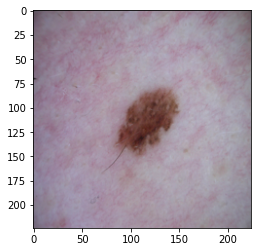

In [50]:
# %pylab inline

i = 7

imshow(X_test_orig[i])
print("Predicted %d // True %d" % (pred_label[i], Y_test_orig[i]))